In [14]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [26]:
actions = [
    '0s',
    '90s',
    '180s'
]

data = np.concatenate([
    np.load('dataset/seq_0s_1667379916.npy'),
    np.load('dataset/seq_0s_1667380955.npy'),
    np.load('dataset/seq_90s_1667379916.npy'),
    np.load('dataset/seq_90s_1667380955.npy'),
    np.load('dataset/seq_180s_1667379916.npy'),
    np.load('dataset/seq_180s_1667380955.npy')
], axis=0)

data.shape

(6811, 30, 100)

In [27]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(6811, 30, 99)
(6811,)


In [28]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(6811, 3)

In [29]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(6129, 30, 99) (6129, 3)
(682, 30, 99) (682, 3)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                41984     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
191/192 [============================>.] - ETA: 0s - loss: 0.3902 - acc: 0.8670
Epoch 1: val_acc improved from -inf to 0.87243, saving model to models\model.h5
192/192 [==============================] - 3s 14ms/step - loss: 0.3899 - acc: 0.8672 - val_loss: 0.3679 - val_acc: 0.8724 - lr: 2.5000e-04
Epoch 2/200
190/192 [============================>.] - ETA: 0s - loss: 0.3520 - acc: 0.8794
Epoch 2: val_acc improved from 0.87243 to 0.87977, saving model to models\model.h5
192/192 [==============================] - 3s 13ms/step - loss: 0.3511 - acc: 0.8798 - val_loss: 0.3525 - val_acc: 0.8798 - lr: 2.5000e-04
Epoch 3/200
188/192 [============================>.] - ETA: 0s - loss: 0.3228 - acc: 0.8956
Epoch 3: val_acc improved from 0.87977 to 0.89736, saving model to models\model.h5
192/192 [==============================] - 3s 13ms/step - loss: 0.3212 - acc: 0.8962 - val_loss: 0.3110 - val_acc: 0.8974 - lr: 2.5000e-04
Epoch 4/200
188/192 [============================>.] - ETA: 0

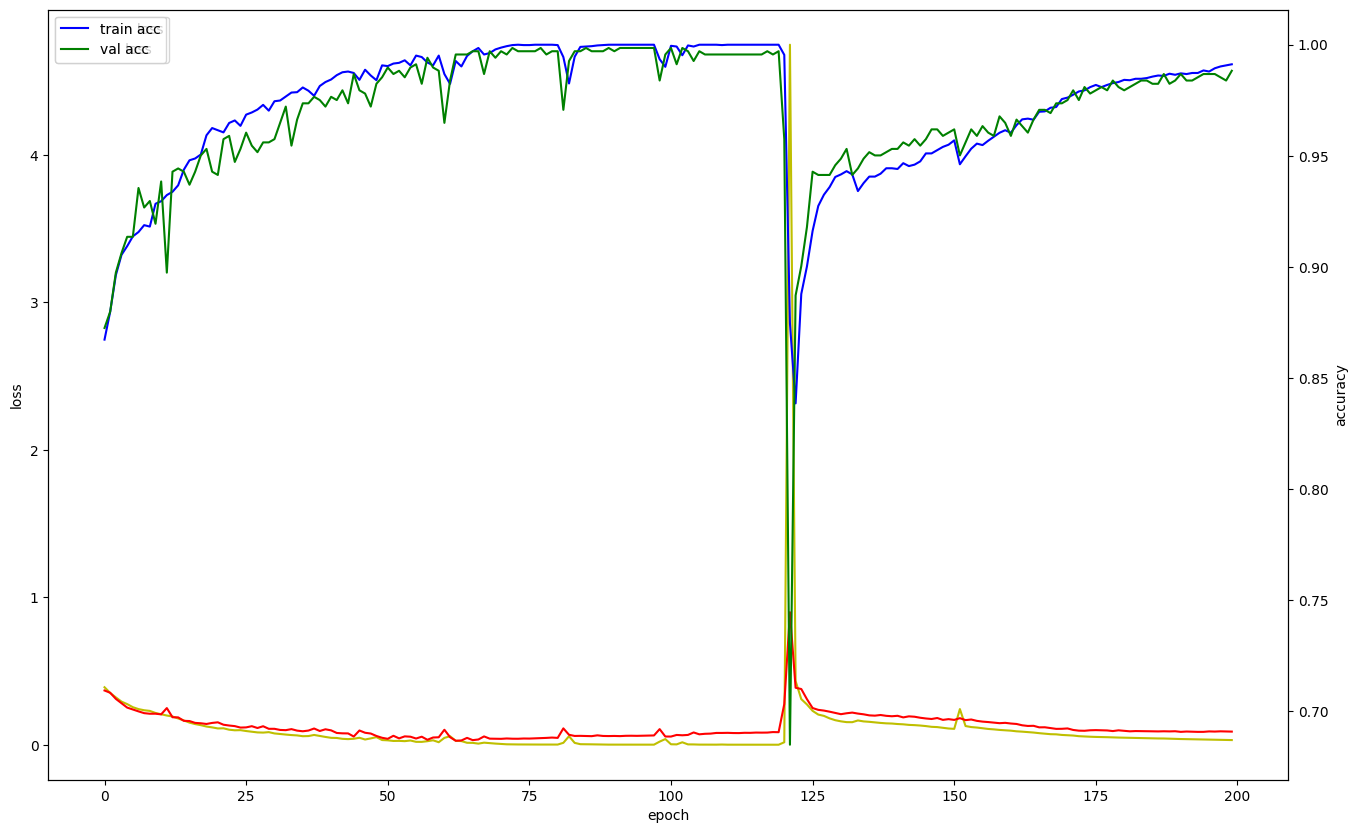

In [35]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [36]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

22/22 [==============================] - 0s 8ms/step


array([[[455,   0],
        [  1, 226]],

       [[444,   0],
        [  0, 238]],

       [[464,   1],
        [  0, 217]]], dtype=int64)